In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [27]:

class TabularNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate, activation_fn):
        super(TabularNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))  # output 1 value for regression
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [28]:
model = TabularNN(
    input_dim=52,
    hidden_dims=[191, 128],
    dropout_rate=0.017276892822033808,
    activation_fn='tanh',
).to(device)



In [29]:

# Load the saved state dictionary
model.load_state_dict(torch.load("best_tabular_model_reduced.pt", map_location=device))
model.eval() # Set the model to evaluation mode

TabularNN(
  (net): Sequential(
    (0): Linear(in_features=52, out_features=191, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.017276892822033808, inplace=False)
    (3): Linear(in_features=191, out_features=128, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.017276892822033808, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [30]:
import shap
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming you have the original dataframe and scaler from your data preparation steps
# (These parts would typically be run again if starting a new script/notebook session)

# Load data (re-run these steps if in a new session)
df = pd.read_pickle('data/trainingData.pkl')

miete_col = ['Gastronomy','All_Buildings','Cycleways','Water_Bodies','Fast_Food','Schools','Green_Areas','Building_Types','v_gsm','Buildings_With_Height_Levels','ko_kasskred','v_breitb50','v_lte','Bio-Läden','Landuse','p_markt','p_apo','bev_binw','heiz_wohn_best','v_5g','p_poli','fl_landw','p_freibad','v_breitb1000','Kindergartens','Health','Playgrounds','p_harzt','p_grunds','pfl_ambu','eauto','v_lte','st_einnkr','p_notfall','beschq_insg','Bio_Shops','mitgl_sportv','erw_mini','straft','elterng_v','p_ozmz_oev','kbetr_ue3','bev_entw','p_nelade','bquali_unifh','p_ozmz_miv','p_sek_2','kinder_bg','All_Highways','wohn_leer']
df = df.drop(columns= miete_col)
X = df.drop(columns=['preis_miet_best'], axis=1).values
y = df['preis_miet_best'].values

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert a small sample of your training data to a PyTorch tensor for the background dataset
# You might choose a larger sample if your dataset is diverse
background_data = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)] # Sample 100 data points
background_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)

# Choose some instances to explain (e.g., from your validation set)
# Convert them to PyTorch tensor
instances_to_explain_data = X_val_scaled # Explain the first 5 validation samples
instances_to_explain_tensor = torch.tensor(instances_to_explain_data, dtype=torch.float32).to(device)

# Get feature names if available (optional, but good for interpretation)
feature_names = df.drop(columns=['preis_miet_best'], axis=1).columns.tolist()

In [31]:
# Create a SHAP DeepExplainer
# The explainer needs the model and the background data
explainer = shap.DeepExplainer(model, background_tensor)# Create a SHAP DeepExplainer


In [32]:
# Calculate SHAP values
shap_values = explainer.shap_values(instances_to_explain_tensor)

In [33]:
import shap
import numpy as np

# ... (your code for loading model, preparing data, creating explainer, calculating shap_values) ...

# VERIFY SHAPES BEFORE PLOTTING
print(f"Shape of explainer.expected_value: {explainer.expected_value.shape}")
print(f"Shape of shap_values[0]: {shap_values[0].shape}")
print(f"Shape of instances_to_explain_data[0:1]: {instances_to_explain_data[0:1].shape}")
print(f"Type of shap_values[0]: {type(shap_values[0])}")
print(f"Type of instances_to_explain_data[0:1]: {type(instances_to_explain_data[0:1])}")


shap.initjs() # Initialize JavaScript for interactive plots in notebooks
shap.force_plot(
    explainer.expected_value.item(), # Convert (1,) array to a scalar
    shap_values[0].squeeze(),        # <--- CHANGE THIS: Squeeze to (100,) from (100, 1)
    instances_to_explain_data[0:1],  # This is correctly (1, 100)
    feature_names=feature_names      # Uncomment and provide actual feature_names if desired
)

Shape of explainer.expected_value: (1,)
Shape of shap_values[0]: (52, 1)
Shape of instances_to_explain_data[0:1]: (1, 52)
Type of shap_values[0]: <class 'numpy.ndarray'>
Type of instances_to_explain_data[0:1]: <class 'numpy.ndarray'>


In [34]:
print(f"Shape of full shap_values array: {shap_values.shape}")

Shape of full shap_values array: (1977, 52, 1)


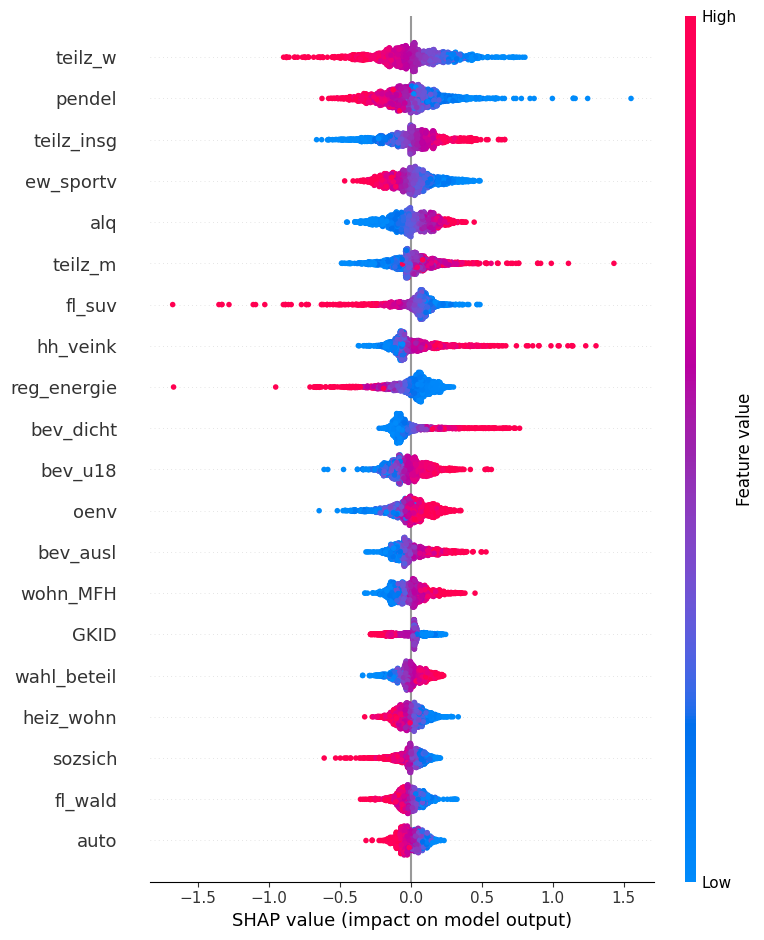

In [37]:
# Assuming 'feature_names' is a list of your 100 feature names

from sympy import plot


shap.summary_plot(
    shap_values.squeeze(), # <--- Squeeze to remove the (100, 1) dimension
    instances_to_explain_data, # Original (or scaled) feature values matching the shap_values
    feature_names=feature_names,
    #plot_type="bar", # Use "bar" for a summary bar plot
    max_display=20 # Display top 20 features 
)


Generating SHAP Summary Plots...

--- SHAP Summary Plot (Dots) ---


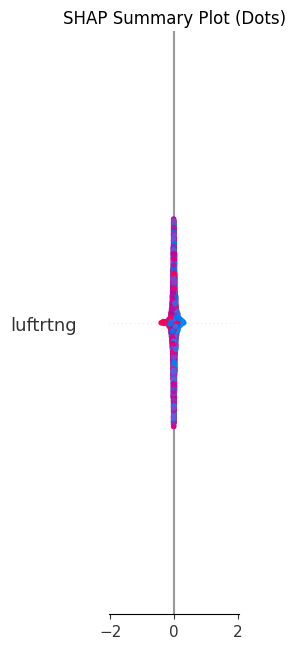


--- SHAP Summary Plot (Bar) ---


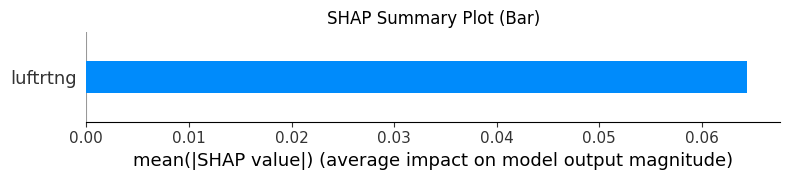

Generating SHAP Dependence Plots...

--- SHAP Dependence Plot for ['luftrtng'] ---


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

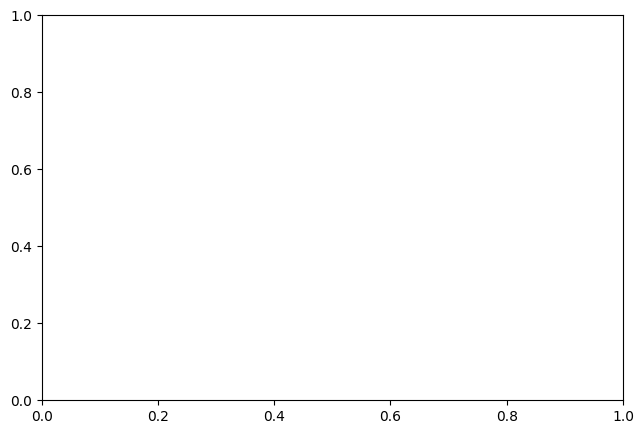

In [42]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'explainer', 'shap_values', 'instances_to_explain_data',
# and 'feature_names' are already defined from your notebook.

# Handle shap_values for DeepExplainer, which often returns a list of arrays.

plot_shap_values = shap_values

# Ensure plot_shap_values is 2D (samples, features) for plots that expect it,
# removing any (N, 1) dimension if present, but keeping (N,) if it's already 1D per sample.
if plot_shap_values.ndim == 2 and plot_shap_values.shape[1] == 1:
    plot_shap_values = plot_shap_values.squeeze(axis=1)
elif plot_shap_values.ndim == 1:
    pass


# Handle base_value for DeepExplainer. It might be a list or array even for a single output.
if isinstance(explainer.expected_value, (list, np.ndarray)):
    # Take the first element for single output, and ensure it's a scalar if it can be.
    base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value.item() if explainer.expected_value.size == 1 else explainer.expected_value[0]
else:
    base_value = explainer.expected_value

# Ensure instances_to_explain_data is a DataFrame for better plotting with feature names
if isinstance(instances_to_explain_data, np.ndarray):
    instances_to_explain_df = pd.DataFrame(instances_to_explain_data, columns=feature_names)
else:
    instances_to_explain_df = instances_to_explain_data

print("Generating SHAP Summary Plots...")

# 1. SHAP Summary Plot (Dots)
# This plot shows the distribution of SHAP values for each feature across all samples.
# Each dot is an observation, and its color indicates the feature value.
print("\n--- SHAP Summary Plot (Dots) ---")
shap.summary_plot(plot_shap_values, instances_to_explain_df, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot (Dots)")
plt.tight_layout()
plt.show()

# 2. SHAP Summary Plot (Bar)
print("\n--- SHAP Summary Plot (Bar) ---")
shap.summary_plot(np.abs(plot_shap_values).mean(0), feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar)")
plt.tight_layout()
plt.show()

print("Generating SHAP Dependence Plots...")

# 3. SHAP Dependence Plots
# Calculate mean absolute SHAP values to find important features.
mean_abs_shap = np.abs(plot_shap_values).mean(0)
top_features_indices = np.argsort(mean_abs_shap)[::-1][:3] # Get indices of top 3 features

# CORRECTED: Convert feature_names to a NumPy array for robust indexing
feature_names_np = np.array(feature_names)
top_feature_names = feature_names_np[top_features_indices].tolist()


for feature in top_feature_names:
    print(f"\n--- SHAP Dependence Plot for {feature} ---")
    shap.dependence_plot(
        feature,
        plot_shap_values, # Use the correctly processed plot_shap_values (N, M)
        instances_to_explain_df,
        feature_names=feature_names,
        interaction_index="auto", # Automatically find best feature to interact with
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {feature}")
    plt.tight_layout()
    plt.show()

print("Generating SHAP Force Plots...")

# 4. SHAP Force Plot (for a single instance)
# This plot visualizes how features contribute to a single prediction's deviation from the base value.
# Let's plot the first instance.
instance_index_to_plot = 0
print(f"\n--- SHAP Force Plot for instance {instance_index_to_plot} ---")
shap.initjs() # Initialize JavaScript for interactive plots (if in Jupyter)
display(shap.force_plot(
    base_value, # Use the correctly processed base_value
    plot_shap_values[instance_index_to_plot], # Use the correct slice of plot_shap_values (M,)
    instances_to_explain_df.iloc[instance_index_to_plot],
    feature_names=feature_names
))

# 5. Corrected SHAP Decision Plot
print("\n--- Corrected SHAP Decision Plot ---")
num_instances_to_plot = min(5, instances_to_explain_df.shape[0]) # Plot a few instances

# Use plot_shap_values which is already processed for dimensions (N, M)
decision_plot_shap_values = plot_shap_values[:num_instances_to_plot]

# base_value is already processed and should be scalar
decision_plot_base_value = base_value

shap.decision_plot(
    base_value=decision_plot_base_value,
    shap_values=decision_plot_shap_values,
    features=instances_to_explain_df.iloc[:num_instances_to_plot],
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Decision Plot")
plt.tight_layout()
plt.show()

print("\nAll requested SHAP plots have been generated.")